In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer

from sklearn import (
    linear_model, 
    ensemble,
    tree,
    decomposition, 
    naive_bayes, 
    neural_network,
    svm,
    metrics,
    preprocessing, 
    model_selection, 
    pipeline,
)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd

import utils

from nltk.corpus import stopwords

stopwords_fr = stopwords.words('french')


red_code = '\033[91m'
blue_code = '\033[94m'
green_code = '\033[92m'
yellow_code = '\033[93m'
reset_code = '\033[0m'

C:\Users\Kadem\AppData\Local\Temp\ipykernel_57008\2165595470.py:34: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Chargement des données 

In [2]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = utils.load_pres(fname)

pres_df = pd.DataFrame()
pres_df['text'] = alltxts
pres_df['label'] = alllabs

In [3]:
preprocessed_alltxts = [utils.preprocess(alltxt) for alltxt in pres_df.text]

preprocessed_pres_df = pd.DataFrame()
preprocessed_pres_df['text'] = preprocessed_alltxts
preprocessed_pres_df['label'] = alllabs

In [4]:
def analyse_pipeline(vectorizer, classifier, X_text_train, y_train, X_text_test, y_test):
    pipe = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
    ])

    pipe.fit(X_text_train, y_train)

    y_pred = pipe.predict(X_text_test)
    report = metrics.classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)
    print("")

    return pipe

## Probléme de désequilibre

On creer un split de test pour le garder plutard pour tester notre modéle, ensuite on devisera chaque partie d'entrainement, en train et validation

In [5]:
X, X_test, y, y_test = model_selection.train_test_split(preprocessed_pres_df['text'], preprocessed_pres_df['label'], test_size=0.2, random_state=24, stratify= preprocessed_pres_df['label'])

In [9]:
X_text_train_rs, X_text_test_rs, y_train_rs, y_test_rs = model_selection.train_test_split(X, y, test_size=0.2, random_state=24, stratify = y)

clf = LogisticRegression()
vct = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)
pipe = analyse_pipeline(vct, clf, X_text_train_rs, y_train_rs, X_text_test_rs, y_test_rs)

Classification Report:
              precision    recall  f1-score   support

          -1       0.82      0.25      0.39      1204
           1       0.90      0.99      0.94      7982

    accuracy                           0.89      9186
   macro avg       0.86      0.62      0.66      9186
weighted avg       0.89      0.89      0.87      9186




l'hyperparametre "class_weight" avec la valeure 'balanced' utilise les valeurs de y pour ajuster automatiquement les poids de manière inversement proportionnelle aux fréquences des classes dans les données d'entrée, comme n_samples / (n_classes * np.bincount(y)).

In [10]:
X_text_train_rs, X_text_test_rs, y_train_rs, y_test_rs = model_selection.train_test_split(X, y, test_size=0.2, random_state=24, stratify = y)

clf = LogisticRegression(class_weight='balanced')
vct = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)
pipe = analyse_pipeline(vct, clf, X_text_train_rs, y_train_rs, X_text_test_rs, y_test_rs)

Classification Report:
              precision    recall  f1-score   support

          -1       0.45      0.72      0.55      1204
           1       0.95      0.87      0.91      7982

    accuracy                           0.85      9186
   macro avg       0.70      0.79      0.73      9186
weighted avg       0.89      0.85      0.86      9186




On remarque un enorme désequilibre dans les classes, la classe minoritaire a un trés mauvais F1 score, et conditions réelle le modéle ne serra pas bien prédire et dinstinguer les deux classes, on va parcourir plusieurs méthodes pour corrigé le probléme

### Sous-échantillonnage de la classe majoritaire

Cette méthode consiste à répliquer aléatoirement les exemples de la classe minoritaire afin d'équilibrer le nombre d'exemples entre les classes.

In [11]:
from imblearn.under_sampling import RandomUnderSampler

# X représente vos données et y représente vos étiquettes
undersampler = RandomUnderSampler()
X_resampled, y_resampled = undersampler.fit_resample(X.to_frame(), y.to_frame())

In [12]:
X_text_train_rs, X_text_test_rs, y_train_rs, y_test_rs = model_selection.train_test_split(X_resampled['text'], y_resampled['label'], test_size=0.2, random_state=24, stratify = y_resampled['label'])

vct = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)
clf = LogisticRegression(class_weight='balanced')
pipe = analyse_pipeline(vct, clf, X_text_train_rs, y_train_rs, X_text_test_rs, y_test_rs)

Classification Report:
              precision    recall  f1-score   support

          -1       0.75      0.82      0.78      1204
           1       0.80      0.72      0.76      1204

    accuracy                           0.77      2408
   macro avg       0.77      0.77      0.77      2408
weighted avg       0.77      0.77      0.77      2408




In [13]:
#On teste si le modéle generralise bien : 
y_pred = pipe.predict(X_test)
report = metrics.classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
print("")

Classification Report:
              precision    recall  f1-score   support

          -1       0.31      0.79      0.44      1505
           1       0.96      0.73      0.83      9978

    accuracy                           0.74     11483
   macro avg       0.63      0.76      0.64     11483
weighted avg       0.87      0.74      0.78     11483




C'est déja mieux, mais ce n'est pas suffisant

### Sur Echantillionage sur la classe minoritaire :

In [14]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()
X_resampled, y_resampled = oversampler.fit_resample(X.to_frame(), y.to_frame())

In [18]:
X_text_train_rs, X_text_test_rs, y_train_rs, y_test_rs = model_selection.train_test_split(X_resampled['text'], y_resampled['label'], test_size=0.2, random_state=24, stratify = y_resampled['label'])

vct = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)
clf = LogisticRegression(class_weight='balanced')
pipe = analyse_pipeline(vct, clf, X_text_train_rs, y_train_rs, X_text_test_rs, y_test_rs)

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.97      0.92      7983
           1       0.97      0.85      0.91      7982

    accuracy                           0.91     15965
   macro avg       0.92      0.91      0.91     15965
weighted avg       0.92      0.91      0.91     15965




In [19]:
#On teste si le modéle generralise bien : 
y_pred = pipe.predict(X_test)
report = metrics.classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
print("")

Classification Report:
              precision    recall  f1-score   support

          -1       0.44      0.74      0.55      1505
           1       0.96      0.86      0.90      9978

    accuracy                           0.84     11483
   macro avg       0.70      0.80      0.72     11483
weighted avg       0.89      0.84      0.86     11483




### Post traitement Gaussian smoothing

In [13]:
def countValue(l):
    d = {-1:0, 1:0}
    for v in l:
        # d[v] = d.get(v, 0) + 1
        d[v] += 1
    return d

def gaussian_smoothing(y, size=1):
    """
    Convolue sur la liste et regarde le nombre de voisin dans la fenêtre centré sur le point.
    Attribue simple la classe la plus présente dans la fenêtre au point centré.
    """
    new_y = y.copy()
    for i in range(size, len(y) - size):
        window = y[i - size : i + size + 1]
        d = countValue(window)
        if d[-1] < d[1]:
            new_y[i] = 1
        elif d[-1] > d[1]:
            new_y[i] = -1
        else:
            pass
    return new_y


In [138]:
X, X_test, y, y_test = model_selection.train_test_split(preprocessed_pres_df['text'], preprocessed_pres_df['label'], test_size=0.2, random_state=24, shuffle=False)
X_text_train_rs, X_text_test_rs, y_train_rs, y_test_rs = model_selection.train_test_split(X, y, test_size=0.2, random_state=24, stratify = y)

size = 5 

pipe = Pipeline([
('vectorizer', TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))),
('classifier', LogisticRegression(class_weight='balanced'))
])

pipe.fit(X_text_train_rs, y_train_rs)

y_pred = pipe.predict(X_test)


In [139]:
report = metrics.classification_report(y_test, y_pred, output_dict=True)
f1_score = report["-1"]["f1-score"]
print(f1_score)


0.4735472679965308


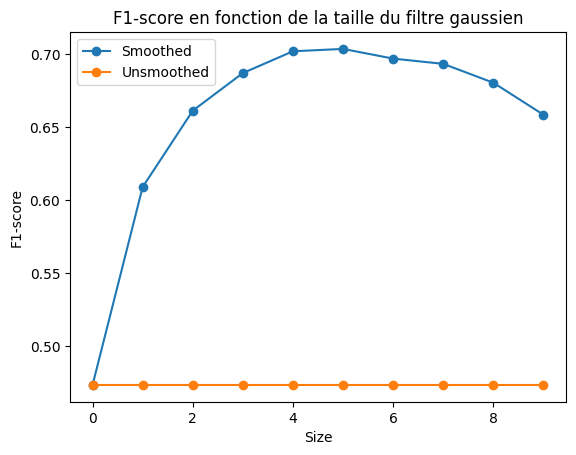

In [141]:
import matplotlib.pyplot as plt

sizes = range(0,10)  # Liste des valeurs de size à essayer
f1_scores_smoothed = []
f1_scores_unsmoothed = []

for size in sizes:
    y_pred_smoothed = gaussian_smoothing(y_pred, size)
    
    report_smoothed = metrics.classification_report(y_test, y_pred_smoothed, output_dict=True)
    f1_score_smoothed = report_smoothed["-1"]["f1-score"]
    f1_scores_smoothed.append(f1_score_smoothed)
    
    report_unsmoothed = metrics.classification_report(y_test, y_pred, output_dict=True)
    f1_score_unsmoothed = report_unsmoothed["-1"]["f1-score"]
    f1_scores_unsmoothed.append(f1_score_unsmoothed)

plt.plot(sizes, f1_scores_smoothed, marker='o', label="Smoothed")
plt.plot(sizes, f1_scores_unsmoothed, marker='o', label="Unsmoothed")
plt.xlabel("Size")
plt.ylabel("F1-score")
plt.title("F1-score en fonction de la taille du filtre gaussien")
plt.legend()
plt.show()

On remarque un assez bon résultat sur les données de test

In [ ]:
from imblearn.over_sampling import SMOTE

x_train_smote, x_test_smote, y_train_smote, y_test_smote = model_selection.train_test_split(X, y, test_size=0.2, random_state=24, stratify = y)

vct = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)
x_train_smote_tfidf = vct.fit_transform(x_train_smote)
x_test_smote_tfidf = vct.transform(x_test_smote)

smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(x_train_smote_tfidf, y_train_smote)

clf = LogisticRegression(class_weight='balanced')

clf.fit(x_train_smote_tfidf, y_train_smote)

y_pred = pipe.predict(x_test_smote_tfidf)
report = metrics.classification_report(y_test_smote, y_pred)
print("Classification Report:")
print(report)
print("")

### Test de la méthode SVD avec la regression logistique : 

In [16]:
X, X_test, y, y_test = model_selection.train_test_split(preprocessed_pres_df['text'], preprocessed_pres_df['label'], test_size=0.2, random_state=24, shuffle=False)
X_train_svd, x_test_svd, y_train_svd, y_test_svd = model_selection.train_test_split(X, y, test_size=0.2, random_state=24, stratify = y)

In [17]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer

# Créer une fonction personnalisée pour la normalisation MinMax
def min_max_normalize(X):
    X_normalized = (X - X.min()) / (X.max() - X.min())
    return X_normalized


pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(sublinear_tf =  True)),
    ('normalize', FunctionTransformer(min_max_normalize, validate=False)),
    ('svd', TruncatedSVD(n_components=5000)),  # Ajout de l'étape SVD
    ('classifier', LogisticRegressionCV(class_weight='balanced'))
])

pipe.fit(X_train_svd, y_train_svd)


y_pred = pipe.predict(x_test_svd)
report = metrics.classification_report(y_test_svd, y_pred)
print("Classification Report:")
print(report)
print("")

Classification Report:
              precision    recall  f1-score   support

          -1       0.44      0.63      0.52      1272
           1       0.94      0.87      0.90      7914

    accuracy                           0.84      9186
   macro avg       0.69      0.75      0.71      9186
weighted avg       0.87      0.84      0.85      9186




In [18]:
y_pred = pipe.predict(X_test)
report = metrics.classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
print("")

Classification Report:
              precision    recall  f1-score   support

          -1       0.32      0.64      0.42      1163
           1       0.95      0.85      0.90     10320

    accuracy                           0.83     11483
   macro avg       0.64      0.74      0.66     11483
weighted avg       0.89      0.83      0.85     11483




In [20]:
y_pred = pipe.predict(X_test)
y_pred = gaussian_smoothing(y_pred, 5)
report = metrics.classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
print("")

Classification Report:
              precision    recall  f1-score   support

          -1       0.74      0.59      0.66      1163
           1       0.96      0.98      0.97     10320

    accuracy                           0.94     11483
   macro avg       0.85      0.79      0.81     11483
weighted avg       0.93      0.94      0.93     11483


